# Entrainement et evaluation des modeles ML - Prediction Crypto

Ce notebook entraine et compare plusieurs modeles de machine learning pour predire le prix de cloture (close) des cryptomonnaies BTC, ETH et SOL a l'horizon t+1 (prochaine periode de 5 minutes).

**Modeles testes :**
- Modeles lineaires : Linear Regression, Ridge, Lasso
- Ensembles d'arbres : Random Forest, XGBoost, LightGBM, CatBoost
- Deep Learning : LSTM, GRU (si TensorFlow est disponible)

Chaque modele est entraine dans deux configurations :
1. **Default** : parametres par defaut
2. **Tuned** : hyperparametres optimises (GridSearch ou manuels)

**Plan du notebook :**
1. Imports et configuration
2. Chargement des donnees
3. Feature engineering
4. Preparation X / y
5. Entrainement des modeles classiques (default puis tuned)
6. Entrainement LSTM / GRU (default puis tuned)
7. Comparaison globale et dashboard
8. Resume

---
## 1. Imports et configuration

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import joblib
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from google.cloud import bigquery

# Repertoires de sortie
os.makedirs('images/training', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [2]:
PROJET_ID="training-gcp-484513"

In [3]:
client = bigquery.Client(project=PROJET_ID)

In [4]:
query = """
SELECT 
    timestamp,
    symbol,
    open,
    high,
    low,
    close,
    volume,
    trades,
    sma_20,
    ema_50,
    rsi_14,
    macd,
    macd_signal,
    bb_upper,
    bb_middle,
    bb_lower
FROM `crypto_analytics.market_data_unified`
WHERE symbol IN ('BTCUSDT', 'ETHUSDT', 'SOLUSDT')
ORDER BY timestamp DESC
"""

---
## 2. Chargement des donnees et formatage des données

In [5]:
df = client.query(query).to_dataframe()
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
colonnes_a_supprimer = ['source', 'ingestion_timestamp', 'date', 'hour', 'day_of_week']
colonnes_existantes = [col for col in colonnes_a_supprimer if col in df.columns]
print(f"Colonnes à supprimer: {colonnes_existantes}")

Colonnes à supprimer: []


In [7]:
df = df.drop(columns=colonnes_existantes)

In [8]:
# Extraire les features temporelles
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek  # 0=Lundi, 6=Dimanche
df['day_of_month'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month

# Features cycliques pour heure (car 23h est proche de 0h)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# Features cycliques pour jour de semaine
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df = df.sort_values('timestamp').reset_index(drop=True)

In [9]:
df['symbol'].value_counts()

symbol
BTCUSDT    643480
ETHUSDT    643480
SOLUSDT    579213
Name: count, dtype: int64

In [10]:
print(f"Lignes restantes: {len(df)}")

Lignes restantes: 1866173


In [11]:
df.isnull().sum()

timestamp         0
symbol            0
open              0
high              0
low               0
close             0
volume            0
trades            0
sma_20          249
ema_50          249
rsi_14          249
macd            249
macd_signal     249
bb_upper        252
bb_middle       249
bb_lower        252
hour              0
day_of_week       0
day_of_month      0
month             0
hour_sin          0
hour_cos          0
day_sin           0
day_cos           0
dtype: int64

In [12]:
datasets = {}

In [13]:
df_btc = df[df['symbol'] == 'BTCUSDT'].copy().reset_index(drop=True)
df_eth = df[df['symbol'] == 'ETHUSDT'].copy().reset_index(drop=True)
df_sol = df[df['symbol'] == 'SOLUSDT'].copy().reset_index(drop=True)

In [14]:
print(f"Dataset BTC: {df_btc.shape[0]} lignes X {df_btc.shape[1]} colonnes")
print(f"Periode: {df_btc['timestamp'].min()} -> {df_btc['timestamp'].max()}")

print(f"Dataset ETH: {df_eth.shape[0]} lignes X {df_eth.shape[1]} colonnes")
print(f"Periode: {df_eth['timestamp'].min()} -> {df_eth['timestamp'].max()}")

print(f"Dataset SOL: {df_sol.shape[0]} lignes X {df_sol.shape[1]} colonnes")
print(f"Periode: {df_sol['timestamp'].min()} -> {df_sol['timestamp'].max()}")

Dataset BTC: 643480 lignes X 24 colonnes
Periode: 2020-01-01 00:00:00+00:00 -> 2026-02-14 00:40:00+00:00
Dataset ETH: 643480 lignes X 24 colonnes
Periode: 2020-01-01 00:00:00+00:00 -> 2026-02-14 00:40:00+00:00
Dataset SOL: 579213 lignes X 24 colonnes
Periode: 2020-08-11 06:00:00+00:00 -> 2026-02-14 00:40:00+00:00


In [15]:
# Supprimer la colonne 'symbol' car elle n'est plus nécessaire
df_btc = df_btc.drop(columns=['symbol'])
df_eth = df_eth.drop(columns=['symbol'])
df_sol = df_sol.drop(columns=['symbol'])

---
### DIVISION TRAIN/TEST TEMPORELLE (70/30)

In [16]:
def split_temporal_data(df, train_ratio=0.7, crypto_name=''):
    # Calculer l'index de séparation
    split_idx = int(len(df) * train_ratio)
    
    # Division temporelle (pas de shuffle!)
    train = df.iloc[:split_idx].copy()
    test = df.iloc[split_idx:].copy()
    
    print(f"{crypto_name}")
    print(f"Total: {len(df)} lignes")
    print(f"Train: {len(train)} lignes ({len(train)/len(df)*100:.1f}%)")
    print(f"Test:  {len(test)} lignes ({len(test)/len(df)*100:.1f}%)")
    print(f"Train période: {train['timestamp'].min()} -> {train['timestamp'].max()}")
    print(f"Test période:  {test['timestamp'].min()} -> {test['timestamp'].max()}")
    
    return train, test



# Division pour BTC
btc_train, btc_test = split_temporal_data(df_btc, train_ratio=0.7, crypto_name='BTC')

# Division pour ETH
eth_train, eth_test = split_temporal_data(df_eth, train_ratio=0.7, crypto_name='ETH')

# Division pour SOL
sol_train, sol_test = split_temporal_data(df_sol, train_ratio=0.7, crypto_name='SOL')

BTC
Total: 643480 lignes
Train: 450436 lignes (70.0%)
Test:  193044 lignes (30.0%)
Train période: 2020-01-01 00:00:00+00:00 -> 2024-04-14 17:20:00+00:00
Test période:  2024-04-14 17:25:00+00:00 -> 2026-02-14 00:40:00+00:00
ETH
Total: 643480 lignes
Train: 450436 lignes (70.0%)
Test:  193044 lignes (30.0%)
Train période: 2020-01-01 00:00:00+00:00 -> 2024-04-14 17:20:00+00:00
Test période:  2024-04-14 17:25:00+00:00 -> 2026-02-14 00:40:00+00:00
SOL
Total: 579213 lignes
Train: 405449 lignes (70.0%)
Test:  173764 lignes (30.0%)
Train période: 2020-08-11 06:00:00+00:00 -> 2024-06-20 16:00:00+00:00
Test période:  2024-06-20 16:05:00+00:00 -> 2026-02-14 00:40:00+00:00


In [17]:
datasets = {
   'btc':{
       'train':btc_train,
       'test':btc_test
   }, 
    'eth':{
       'train':eth_train,
       'test':eth_test
   }, 
   'sol':{
       'train':sol_train,
       'test':sol_test
   }
}

In [18]:
for name in ['btc', 'eth', 'sol']:
    tr, te = datasets[name]['train'], datasets[name]['test']
    print(f"{name.upper()} - Train: {tr.shape}, Test: {te.shape}")

BTC - Train: (450436, 23), Test: (193044, 23)
ETH - Train: (450436, 23), Test: (193044, 23)
SOL - Train: (405449, 23), Test: (173764, 23)


---
## 3. Feature engineering

On enrichit les donnees avec des features de lag (valeurs passees), des moyennes mobiles et des indicateurs de variation. Ces features permettent aux modeles de capturer la dynamique temporelle du marche.

In [19]:
def create_lag_features(df, n_lags=12):
    df = df.copy()

    for i in range(1, n_lags + 1):
        df[f'close_lag_{i}'] = df['close'].shift(i)

    for i in range(1, 4):
        df[f'volume_lag_{i}'] = df['volume'].shift(i)

    df['close_rolling_mean_5'] = df['close'].rolling(5).mean()
    df['close_rolling_mean_20'] = df['close'].rolling(20).mean()
    df['close_rolling_std_20'] = df['close'].rolling(20).std()

    df['price_change'] = df['close'].diff()
    df['price_change_pct'] = df['close'].pct_change() * 100
    df['volume_change'] = df['volume'].diff()

    df['hl_spread'] = df['high'] - df['low']
    df['hl_spread_pct'] = (df['hl_spread'] / df['close']) * 100

    return df


for name in datasets:
    datasets[name]['train'] = create_lag_features(datasets[name]['train']).dropna().reset_index(drop=True)
    datasets[name]['test'] = create_lag_features(datasets[name]['test']).dropna().reset_index(drop=True)

for name in datasets:
    tr, te = datasets[name]['train'], datasets[name]['test']
    print(f"{name.upper()} apres feature engineering - Train: {tr.shape}, Test: {te.shape}")

BTC apres feature engineering - Train: (450417, 46), Test: (192942, 46)
ETH apres feature engineering - Train: (450417, 46), Test: (192942, 46)
SOL apres feature engineering - Train: (405430, 46), Test: (173662, 46)


---
## 4. Preparation X / y

La target est le prix de cloture de la periode suivante (t+1). Les features sont normalisees avec StandardScaler.

In [20]:
def prepare_data_for_ml(train_df, test_df):
    exclude_cols = ['timestamp', 'close']
    feature_cols = [c for c in train_df.columns if c not in exclude_cols]

    y_train = train_df['close'].shift(-1).iloc[:-1]
    y_test = test_df['close'].shift(-1).iloc[:-1]

    X_train = train_df[feature_cols].iloc[:-1]
    X_test = test_df[feature_cols].iloc[:-1]

    ts_train = train_df['timestamp'].iloc[:-1]
    ts_test = test_df['timestamp'].iloc[:-1]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, ts_train, ts_test, scaler, feature_cols


ml_data = {}
for name in datasets:
    ml_data[name] = prepare_data_for_ml(datasets[name]['train'], datasets[name]['test'])
    X_tr, X_te = ml_data[name][0], ml_data[name][1]
    print(f"{name.upper()} - X_train: {X_tr.shape}, X_test: {X_te.shape}, features: {X_tr.shape[1]}")

BTC - X_train: (450416, 44), X_test: (192941, 44), features: 44
ETH - X_train: (450416, 44), X_test: (192941, 44), features: 44
SOL - X_train: (405429, 44), X_test: (173661, 44), features: 44


---
## 5. Fonctions utilitaires

Fonctions partagees pour l'evaluation et la visualisation des predictions.

In [21]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calcule MAE, RMSE, R2 et MAPE."""
    return {
        'Model': model_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100,
    }


def plot_predictions(timestamps, y_true, y_pred, title, filename):
    """Trace predictions vs reel + erreurs, et sauvegarde dans images/training/."""
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    axes[0].plot(timestamps, y_true, label='Reel', color='blue', linewidth=2, alpha=0.8)
    axes[0].plot(timestamps, y_pred, label='Prediction', color='red', linewidth=2, alpha=0.8, linestyle='--')
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Prix (USD)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    errors = np.asarray(y_true) - np.asarray(y_pred)
    axes[1].plot(timestamps, errors, color='purple', linewidth=1, alpha=0.7)
    axes[1].axhline(y=0, color='black', linewidth=1)
    axes[1].fill_between(timestamps, errors, 0, where=(errors > 0), color='green', alpha=0.3, label='Sous-estimation')
    axes[1].fill_between(timestamps, errors, 0, where=(errors < 0), color='red', alpha=0.3, label='Sur-estimation')
    axes[1].set_title('Erreurs de prediction', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Date')
    axes[1].set_ylabel('Erreur (USD)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'images/training/{filename}', dpi=300, bbox_inches='tight')
    plt.close()

---
## 6. Entrainement des modeles classiques (default)

On entraine les 7 modeles classiques avec leurs parametres par defaut pour etablir une baseline.

In [22]:
def get_default_models():
    return {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbose=-1),
        'CatBoost': CatBoostRegressor(iterations=100, random_state=42, verbose=0),
    }

def train_all_models(models_dict, X_train, X_test, y_train, y_test, ts_test, crypto_name, suffix='default'):
    results = []
    trained = {}
    
    # Créer le dossier models s'il n'existe pas
    os.makedirs('models', exist_ok=True)
    
    for name, model in models_dict.items():
        model_filename = f'models/{crypto_name.lower()}_{name.lower().replace(" ", "_")}_{suffix}.joblib'
        
        # Vérifier si le modèle existe déjà
        if os.path.exists(model_filename):
            print(f"Chargement du modèle existant: {model_filename}")
            trained_model = joblib.load(model_filename)
        else:
            print(f"Entraînement du modèle: {name}")
            model.fit(X_train, y_train)
            trained_model = model
            joblib.dump(trained_model, model_filename)
            print(f"Modèle sauvegardé: {model_filename}")
        
        # Évaluation du modèle (chargé ou fraîchement entraîné)
        y_pred = trained_model.predict(X_test)
        label = f"{name} ({suffix.capitalize()})" if suffix != 'default' else name
        metrics = evaluate_model(y_test, y_pred, label)
        results.append(metrics)
        trained[name] = trained_model
        
        plot_predictions(
            ts_test, y_test, y_pred,
            f'{crypto_name} - {label}',
            f'{crypto_name.lower()}_{name.lower().replace(" ", "_")}_{suffix}.png'
        )
    
    return results, trained

In [23]:
results_default = {}
models_default = {}

for name in ['btc', 'eth', 'sol']:
    X_tr, X_te, y_tr, y_te, ts_tr, ts_te, scaler, feats = ml_data[name]
    
    # Gérer le scaler
    scaler_filename = f'models/{name.lower()}_scaler_default.joblib'
    if os.path.exists(scaler_filename):
        print(f"Chargement du scaler existant: {scaler_filename}")
        scaler = joblib.load(scaler_filename)
    else:
        print(f"Sauvegarde du nouveau scaler: {scaler_filename}")
        joblib.dump(scaler, scaler_filename)
    
    print(f"--- {name.upper()} (default) ---")
    res, mdls = train_all_models(get_default_models(), X_tr, X_te, y_tr, y_te, ts_te, name.upper())
    results_default[name.upper()] = res
    models_default[name.upper()] = mdls

Chargement du scaler existant: models/btc_scaler_default.joblib
--- BTC (default) ---
Chargement du modèle existant: models/btc_linear_regression_default.joblib
Chargement du modèle existant: models/btc_ridge_default.joblib
Chargement du modèle existant: models/btc_lasso_default.joblib
Chargement du modèle existant: models/btc_random_forest_default.joblib
Chargement du modèle existant: models/btc_xgboost_default.joblib
Chargement du modèle existant: models/btc_lightgbm_default.joblib
Chargement du modèle existant: models/btc_catboost_default.joblib
Chargement du scaler existant: models/eth_scaler_default.joblib
--- ETH (default) ---
Chargement du modèle existant: models/eth_linear_regression_default.joblib
Chargement du modèle existant: models/eth_ridge_default.joblib
Chargement du modèle existant: models/eth_lasso_default.joblib
Chargement du modèle existant: models/eth_random_forest_default.joblib
Chargement du modèle existant: models/eth_xgboost_default.joblib
Chargement du modèle e

### Resultats default

In [24]:
for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    df_res = pd.DataFrame(results_default[crypto]).sort_values('R2', ascending=False)
    display(df_res)

--- BTC ---


,Model,MAE,RMSE,R2,MAPE
0,Linear Regression,82.301269,129.069188,0.999956,0.095877
2,Lasso,82.427586,129.119435,0.999956,0.096007
1,Ridge,82.475019,129.356612,0.999956,0.096084
3,Random Forest,17978.125542,23753.549127,-0.486189,17.345301
5,LightGBM,19338.834661,25261.633699,-0.680892,18.736998
6,CatBoost,19349.871048,25267.954705,-0.681733,18.752259
4,XGBoost,19497.632075,25450.783629,-0.706158,18.894665


--- ETH ---


,Model,MAE,RMSE,R2,MAPE
0,Linear Regression,4.138819,6.472524,0.999919,0.137900
1,Ridge,4.142473,6.488151,0.999919,0.138041
2,Lasso,4.350466,6.727947,0.999913,0.144253
3,Random Forest,4.608304,7.236481,0.999899,0.153289
5,LightGBM,7.124549,11.441128,0.999748,0.222031
4,XGBoost,7.626577,12.244340,0.999711,0.239846
6,CatBoost,33.076068,64.094573,0.992093,1.055503


--- SOL ---


,Model,MAE,RMSE,R2,MAPE
0,Linear Regression,0.297907,0.464713,0.999842,0.177874
1,Ridge,0.298565,0.466038,0.999841,0.178262
3,Random Forest,0.369598,0.884555,0.999426,0.212743
5,LightGBM,0.822636,1.852237,0.997484,0.446948
2,Lasso,1.777615,1.976243,0.997136,1.038697
6,CatBoost,0.964156,2.041487,0.996944,0.536112
4,XGBoost,0.906949,2.111402,0.996731,0.487516


---
## 7. Entrainement des modeles classiques (tuned)

On optimise les hyperparametres via GridSearchCV pour Ridge, Lasso et Random Forest, et on utilise des parametres manuellement choisis pour les modeles de boosting.

In [25]:
def get_tuned_models(X_train, y_train, crypto_name):   
    # Créer le dossier models s'il n'existe pas
    os.makedirs('models', exist_ok=True)
    
    tuned_models = {}
    
    # Linear Regression (pas de tuning)
    tuned_models['Linear Regression'] = LinearRegression()
    
    # Ridge avec GridSearch
    ridge_filename = f'models/{crypto_name.lower()}_ridge_tuned.joblib'
    if os.path.exists(ridge_filename):
        print(f"Chargement Ridge tuné existant: {ridge_filename}")
        tuned_models['Ridge'] = joblib.load(ridge_filename)
    else:
        print("Tuning Ridge...")
        ridge_grid = GridSearchCV(
            Ridge(), {'alpha': [0.01, 0.1, 1, 10, 100]},
            cv=3, scoring='neg_mean_squared_error', n_jobs=-1
        )
        ridge_grid.fit(X_train, y_train)
        print(f"Ridge best alpha: {ridge_grid.best_params_['alpha']}")
        tuned_models['Ridge'] = ridge_grid.best_estimator_
        joblib.dump(ridge_grid.best_estimator_, ridge_filename)
    
    # Lasso avec GridSearch
    lasso_filename = f'models/{crypto_name.lower()}_lasso_tuned.joblib'
    if os.path.exists(lasso_filename):
        print(f"Chargement Lasso tuné existant: {lasso_filename}")
        tuned_models['Lasso'] = joblib.load(lasso_filename)
    else:
        print("Tuning Lasso...")
        lasso_grid = GridSearchCV(
            Lasso(), {'alpha': [0.01, 0.1, 1, 10]},
            cv=3, scoring='neg_mean_squared_error', n_jobs=-1
        )
        lasso_grid.fit(X_train, y_train)
        print(f"Lasso best alpha: {lasso_grid.best_params_['alpha']}")
        tuned_models['Lasso'] = lasso_grid.best_estimator_
        joblib.dump(lasso_grid.best_estimator_, lasso_filename)
    
    # Random Forest avec GridSearch
    rf_filename = f'models/{crypto_name.lower()}_random_forest_tuned.joblib'
    if os.path.exists(rf_filename):
        print(f"Chargement Random Forest tuné existant: {rf_filename}")
        tuned_models['Random Forest'] = joblib.load(rf_filename)
    else:
        print("Tuning Random Forest...")
        rf_grid = GridSearchCV(
            RandomForestRegressor(random_state=42, n_jobs=-1),
            {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5]},
            cv=3, scoring='neg_mean_squared_error', n_jobs=-1
        )
        rf_grid.fit(X_train, y_train)
        print(f"RF best params: {rf_grid.best_params_}")
        tuned_models['Random Forest'] = rf_grid.best_estimator_
        joblib.dump(rf_grid.best_estimator_, rf_filename)
    
    # Les autres modèles avec paramètres fixes optimisés
    tuned_models['XGBoost'] = xgb.XGBRegressor(
        n_estimators=200, max_depth=7, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
    )
    tuned_models['LightGBM'] = lgb.LGBMRegressor(
        n_estimators=200, max_depth=7, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, verbose=-1
    )
    tuned_models['CatBoost'] = CatBoostRegressor(
        iterations=200, depth=7, learning_rate=0.1, random_state=42, verbose=0
    )
    
    return tuned_models

results_tuned = {}
models_tuned = {}

for name in ['btc', 'eth', 'sol']:
    X_tr, X_te, y_tr, y_te, ts_tr, ts_te, scaler, feats = ml_data[name]
    
    # Gérer le scaler
    scaler_filename = f'models/{name.lower()}_scaler_tuned.joblib'
    if os.path.exists(scaler_filename):
        print(f"Chargement du scaler tuned existant: {scaler_filename}")
        scaler = joblib.load(scaler_filename)
    else:
        print(f"Sauvegarde du nouveau scaler tuned: {scaler_filename}")
        joblib.dump(scaler, scaler_filename)
    
    print(f"\n--- {name.upper()} (tuned) ---")
    tuned_models = get_tuned_models(X_tr, y_tr, name)
    res, mdls = train_all_models(tuned_models, X_tr, X_te, y_tr, y_te, ts_te, name.upper(), suffix='tuned')
    results_tuned[name.upper()] = res
    models_tuned[name.upper()] = mdls

Chargement du scaler tuned existant: models/btc_scaler_tuned.joblib

--- BTC (tuned) ---
Chargement Ridge tuné existant: models/btc_ridge_tuned.joblib
Chargement Lasso tuné existant: models/btc_lasso_tuned.joblib
Chargement Random Forest tuné existant: models/btc_random_forest_tuned.joblib
Chargement du modèle existant: models/btc_linear_regression_tuned.joblib
Chargement du modèle existant: models/btc_ridge_tuned.joblib
Chargement du modèle existant: models/btc_lasso_tuned.joblib
Chargement du modèle existant: models/btc_random_forest_tuned.joblib
Chargement du modèle existant: models/btc_xgboost_tuned.joblib
Chargement du modèle existant: models/btc_lightgbm_tuned.joblib
Chargement du modèle existant: models/btc_catboost_tuned.joblib
Chargement du scaler tuned existant: models/eth_scaler_tuned.joblib

--- ETH (tuned) ---
Chargement Ridge tuné existant: models/eth_ridge_tuned.joblib
Chargement Lasso tuné existant: models/eth_lasso_tuned.joblib
Chargement Random Forest tuné existant: m

### Resultats tuned

In [26]:
for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    df_res = pd.DataFrame(results_tuned[crypto]).sort_values('R2', ascending=False)
    display(df_res)

--- BTC ---


,Model,MAE,RMSE,R2,MAPE
2,Lasso (Tuned),82.293753,128.980371,0.999956,0.095866
1,Ridge (Tuned),82.301713,129.069165,0.999956,0.095877
0,Linear Regression (Tuned),82.301269,129.069188,0.999956,0.095877
3,Random Forest (Tuned),17983.586615,23759.926710,-0.486987,17.350758
6,CatBoost (Tuned),19226.495587,25105.593385,-0.660190,18.635197
5,LightGBM (Tuned),19422.049351,25357.555617,-0.693681,18.820955
4,XGBoost (Tuned),19495.817731,25446.052131,-0.705524,18.893191


--- ETH ---


,Model,MAE,RMSE,R2,MAPE
2,Lasso (Tuned),4.134833,6.467162,0.999920,0.137767
0,Linear Regression (Tuned),4.138819,6.472524,0.999919,0.137900
1,Ridge (Tuned),4.139002,6.473533,0.999919,0.137904
3,Random Forest (Tuned),4.690307,7.377494,0.999895,0.156513
5,LightGBM (Tuned),7.100156,11.522304,0.999744,0.221564
4,XGBoost (Tuned),7.262419,11.868132,0.999729,0.227226
6,CatBoost (Tuned),16.929967,23.924415,0.998898,0.547901


--- SOL ---


,Model,MAE,RMSE,R2,MAPE
1,Ridge (Tuned),0.297913,0.464710,0.999842,0.177878
0,Linear Regression (Tuned),0.297907,0.464713,0.999842,0.177874
2,Lasso (Tuned),0.298421,0.465118,0.999841,0.178154
3,Random Forest (Tuned),0.370361,0.873815,0.999440,0.213703
5,LightGBM (Tuned),0.818093,1.848872,0.997493,0.446394
6,CatBoost (Tuned),1.044010,1.963542,0.997173,0.597988
4,XGBoost (Tuned),0.848367,2.008297,0.997042,0.455594


### Comparaison default vs tuned

In [27]:
comparison_data = []

for crypto in ['BTC', 'ETH', 'SOL']:
    df_def = pd.DataFrame(results_default[crypto])
    df_tun = pd.DataFrame(results_tuned[crypto])

    for i in range(len(df_def)):
        model_base = df_def.iloc[i]['Model']
        comparison_data.append({
            'Crypto': crypto,
            'Model': model_base,
            'R2 Default': round(df_def.iloc[i]['R2'], 4),
            'R2 Tuned': round(df_tun.iloc[i]['R2'], 4),
            'Delta R2': round(df_tun.iloc[i]['R2'] - df_def.iloc[i]['R2'], 4),
            'RMSE Default': round(df_def.iloc[i]['RMSE'], 2),
            'RMSE Tuned': round(df_tun.iloc[i]['RMSE'], 2),
        })

df_comparison = pd.DataFrame(comparison_data)

for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    display(df_comparison[df_comparison['Crypto'] == crypto])

--- BTC ---


,Crypto,Model,R2 Default,R2 Tuned,Delta R2,RMSE Default,RMSE Tuned
0,BTC,Linear Regression,1.0000,1.0000,0.0000,129.07,129.07
1,BTC,Ridge,1.0000,1.0000,0.0000,129.36,129.07
2,BTC,Lasso,1.0000,1.0000,0.0000,129.12,128.98
3,BTC,Random Forest,-0.4862,-0.4870,-0.0008,23753.55,23759.93
4,BTC,XGBoost,-0.7062,-0.7055,0.0006,25450.78,25446.05
5,BTC,LightGBM,-0.6809,-0.6937,-0.0128,25261.63,25357.56
6,BTC,CatBoost,-0.6817,-0.6602,0.0215,25267.95,25105.59


--- ETH ---


,Crypto,Model,R2 Default,R2 Tuned,Delta R2,RMSE Default,RMSE Tuned
7,ETH,Linear Regression,0.9999,0.9999,0.0000,6.47,6.47
8,ETH,Ridge,0.9999,0.9999,0.0000,6.49,6.47
9,ETH,Lasso,0.9999,0.9999,0.0000,6.73,6.47
10,ETH,Random Forest,0.9999,0.9999,-0.0000,7.24,7.38
11,ETH,XGBoost,0.9997,0.9997,0.0000,12.24,11.87
12,ETH,LightGBM,0.9997,0.9997,-0.0000,11.44,11.52
13,ETH,CatBoost,0.9921,0.9989,0.0068,64.09,23.92


--- SOL ---


,Crypto,Model,R2 Default,R2 Tuned,Delta R2,RMSE Default,RMSE Tuned
14,SOL,Linear Regression,0.9998,0.9998,0.0000,0.46,0.46
15,SOL,Ridge,0.9998,0.9998,0.0000,0.47,0.46
16,SOL,Lasso,0.9971,0.9998,0.0027,1.98,0.47
17,SOL,Random Forest,0.9994,0.9994,0.0000,0.88,0.87
18,SOL,XGBoost,0.9967,0.9970,0.0003,2.11,2.01
19,SOL,LightGBM,0.9975,0.9975,0.0000,1.85,1.85
20,SOL,CatBoost,0.9969,0.9972,0.0002,2.04,1.96


---
## 8. Entrainement LSTM / GRU

Les modeles LSTM et GRU sont des reseaux de neurones recurrents adaptes aux series temporelles. Ils prennent en entree des sequences de N pas de temps passes pour predire la valeur suivante.

On utilise des sequences de 60 pas (= 5 heures de donnees a 5 min).

In [28]:
N_STEPS = 60

def create_sequences(train_df, test_df, n_steps=N_STEPS, crypto_name=None):
    # Créer le dossier models s'il n'existe pas
    os.makedirs('models', exist_ok=True)
    
    feature_cols = [c for c in train_df.columns if c != 'timestamp']
    
    # Chemins des scalers
    scaler_X_filename = f'models/{crypto_name.lower()}_scaler_X_lstm.joblib' if crypto_name else None
    scaler_y_filename = f'models/{crypto_name.lower()}_scaler_y_lstm.joblib' if crypto_name else None
    
    # Charger ou créer scaler_X
    if scaler_X_filename and os.path.exists(scaler_X_filename):
        print(f"Chargement scaler_X existant: {scaler_X_filename}")
        scaler_X = joblib.load(scaler_X_filename)
        X_train_raw = scaler_X.transform(train_df[feature_cols].values)
    else:
        scaler_X = StandardScaler()
        X_train_raw = scaler_X.fit_transform(train_df[feature_cols].values)
        if scaler_X_filename:
            joblib.dump(scaler_X, scaler_X_filename)
            print(f"Scaler_X sauvegardé: {scaler_X_filename}")
    
    # Charger ou créer scaler_y
    if scaler_y_filename and os.path.exists(scaler_y_filename):
        print(f"Chargement scaler_y existant: {scaler_y_filename}")
        scaler_y = joblib.load(scaler_y_filename)
        y_train_raw = scaler_y.transform(train_df['close'].values.reshape(-1, 1))
    else:
        scaler_y = StandardScaler()
        y_train_raw = scaler_y.fit_transform(train_df['close'].values.reshape(-1, 1))
        if scaler_y_filename:
            joblib.dump(scaler_y, scaler_y_filename)
            print(f"Scaler_y sauvegardé: {scaler_y_filename}")
    
    # Transformer les données de test (toujours avec transform)
    X_test_raw = scaler_X.transform(test_df[feature_cols].values)
    y_test_raw = scaler_y.transform(test_df['close'].values.reshape(-1, 1))
    
    def _make_seq(X, y, timestamps):
        Xs, ys, ts = [], [], []
        for i in range(n_steps, len(X)):
            Xs.append(X[i - n_steps:i])
            ys.append(y[i])
            ts.append(timestamps.iloc[i])
        return np.array(Xs), np.array(ys), ts
    
    X_train_seq, y_train_seq, _ = _make_seq(X_train_raw, y_train_raw, train_df['timestamp'])
    X_test_seq, y_test_seq, ts_test = _make_seq(X_test_raw, y_test_raw, test_df['timestamp'])
    
    return X_train_seq, y_train_seq, X_test_seq, y_test_seq, ts_test, scaler_y, scaler_X

seq_data = {}
for name in ['btc', 'eth', 'sol']:
    print(f"\n--- Création séquences {name.upper()} ---")
    seq_data[name] = create_sequences(
        datasets[name]['train'], 
        datasets[name]['test'],
        crypto_name=name
    )
    X_tr_s = seq_data[name][0]
    X_te_s = seq_data[name][2]
    scaler_y = seq_data[name][5]
    scaler_X = seq_data[name][6]
    
    print(f"{name.upper()} - Train seq: {X_tr_s.shape}, Test seq: {X_te_s.shape}")


--- Création séquences BTC ---
Scaler_X sauvegardé: models/btc_scaler_X_lstm.joblib
Scaler_y sauvegardé: models/btc_scaler_y_lstm.joblib
BTC - Train seq: (450357, 60, 45), Test seq: (192882, 60, 45)

--- Création séquences ETH ---
Scaler_X sauvegardé: models/eth_scaler_X_lstm.joblib
Scaler_y sauvegardé: models/eth_scaler_y_lstm.joblib
ETH - Train seq: (450357, 60, 45), Test seq: (192882, 60, 45)

--- Création séquences SOL ---
Scaler_X sauvegardé: models/sol_scaler_X_lstm.joblib
Scaler_y sauvegardé: models/sol_scaler_y_lstm.joblib
SOL - Train seq: (405370, 60, 45), Test seq: (173602, 60, 45)


---
## 9. Dashboard de comparaison globale

On rassemble les resultats de tous les modeles (classiques + deep learning, default + tuned) dans un tableau et un dashboard visuel.

In [32]:
# Construire le tableau recapitulatif complet
model_names_classic = ['Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']

recap_rows = []

for crypto in ['BTC', 'ETH', 'SOL']:
    df_def = pd.DataFrame(results_default[crypto])
    df_tun = pd.DataFrame(results_tuned[crypto])

    for i in range(len(df_def)):
        recap_rows.append({
            'Crypto': crypto,
            'Modele': df_def.iloc[i]['Model'],
            'R2 Default': round(df_def.iloc[i]['R2'], 4),
            'R2 Tuned': round(df_tun.iloc[i]['R2'], 4),
            'MAE Tuned': round(df_tun.iloc[i]['MAE'], 2),
            'RMSE Tuned': round(df_tun.iloc[i]['RMSE'], 2),
        })


df_recap = pd.DataFrame(recap_rows)

for crypto in ['BTC', 'ETH', 'SOL']:
    print(f"--- {crypto} ---")
    display(df_recap[df_recap['Crypto'] == crypto].sort_values('R2 Tuned', ascending=False))

# Sauvegarder
df_recap.to_csv('results_summary_all_models.csv', index=False)
print("Tableau sauvegarde dans datasets/results_summary_all_models.csv")

--- BTC ---


,Crypto,Modele,R2 Default,R2 Tuned,MAE Tuned,RMSE Tuned
0,BTC,Linear Regression,1.0000,1.0000,82.30,129.07
1,BTC,Ridge,1.0000,1.0000,82.30,129.07
2,BTC,Lasso,1.0000,1.0000,82.29,128.98
3,BTC,Random Forest,-0.4862,-0.4870,17983.59,23759.93
6,BTC,CatBoost,-0.6817,-0.6602,19226.50,25105.59
5,BTC,LightGBM,-0.6809,-0.6937,19422.05,25357.56
4,BTC,XGBoost,-0.7062,-0.7055,19495.82,25446.05


--- ETH ---


,Crypto,Modele,R2 Default,R2 Tuned,MAE Tuned,RMSE Tuned
7,ETH,Linear Regression,0.9999,0.9999,4.14,6.47
8,ETH,Ridge,0.9999,0.9999,4.14,6.47
9,ETH,Lasso,0.9999,0.9999,4.13,6.47
10,ETH,Random Forest,0.9999,0.9999,4.69,7.38
11,ETH,XGBoost,0.9997,0.9997,7.26,11.87
12,ETH,LightGBM,0.9997,0.9997,7.10,11.52
13,ETH,CatBoost,0.9921,0.9989,16.93,23.92


--- SOL ---


,Crypto,Modele,R2 Default,R2 Tuned,MAE Tuned,RMSE Tuned
14,SOL,Linear Regression,0.9998,0.9998,0.30,0.46
15,SOL,Ridge,0.9998,0.9998,0.30,0.46
16,SOL,Lasso,0.9971,0.9998,0.30,0.47
17,SOL,Random Forest,0.9994,0.9994,0.37,0.87
19,SOL,LightGBM,0.9975,0.9975,0.82,1.85
20,SOL,CatBoost,0.9969,0.9972,1.04,1.96
18,SOL,XGBoost,0.9967,0.9970,0.85,2.01


Tableau sauvegarde dans datasets/results_summary_all_models.csv


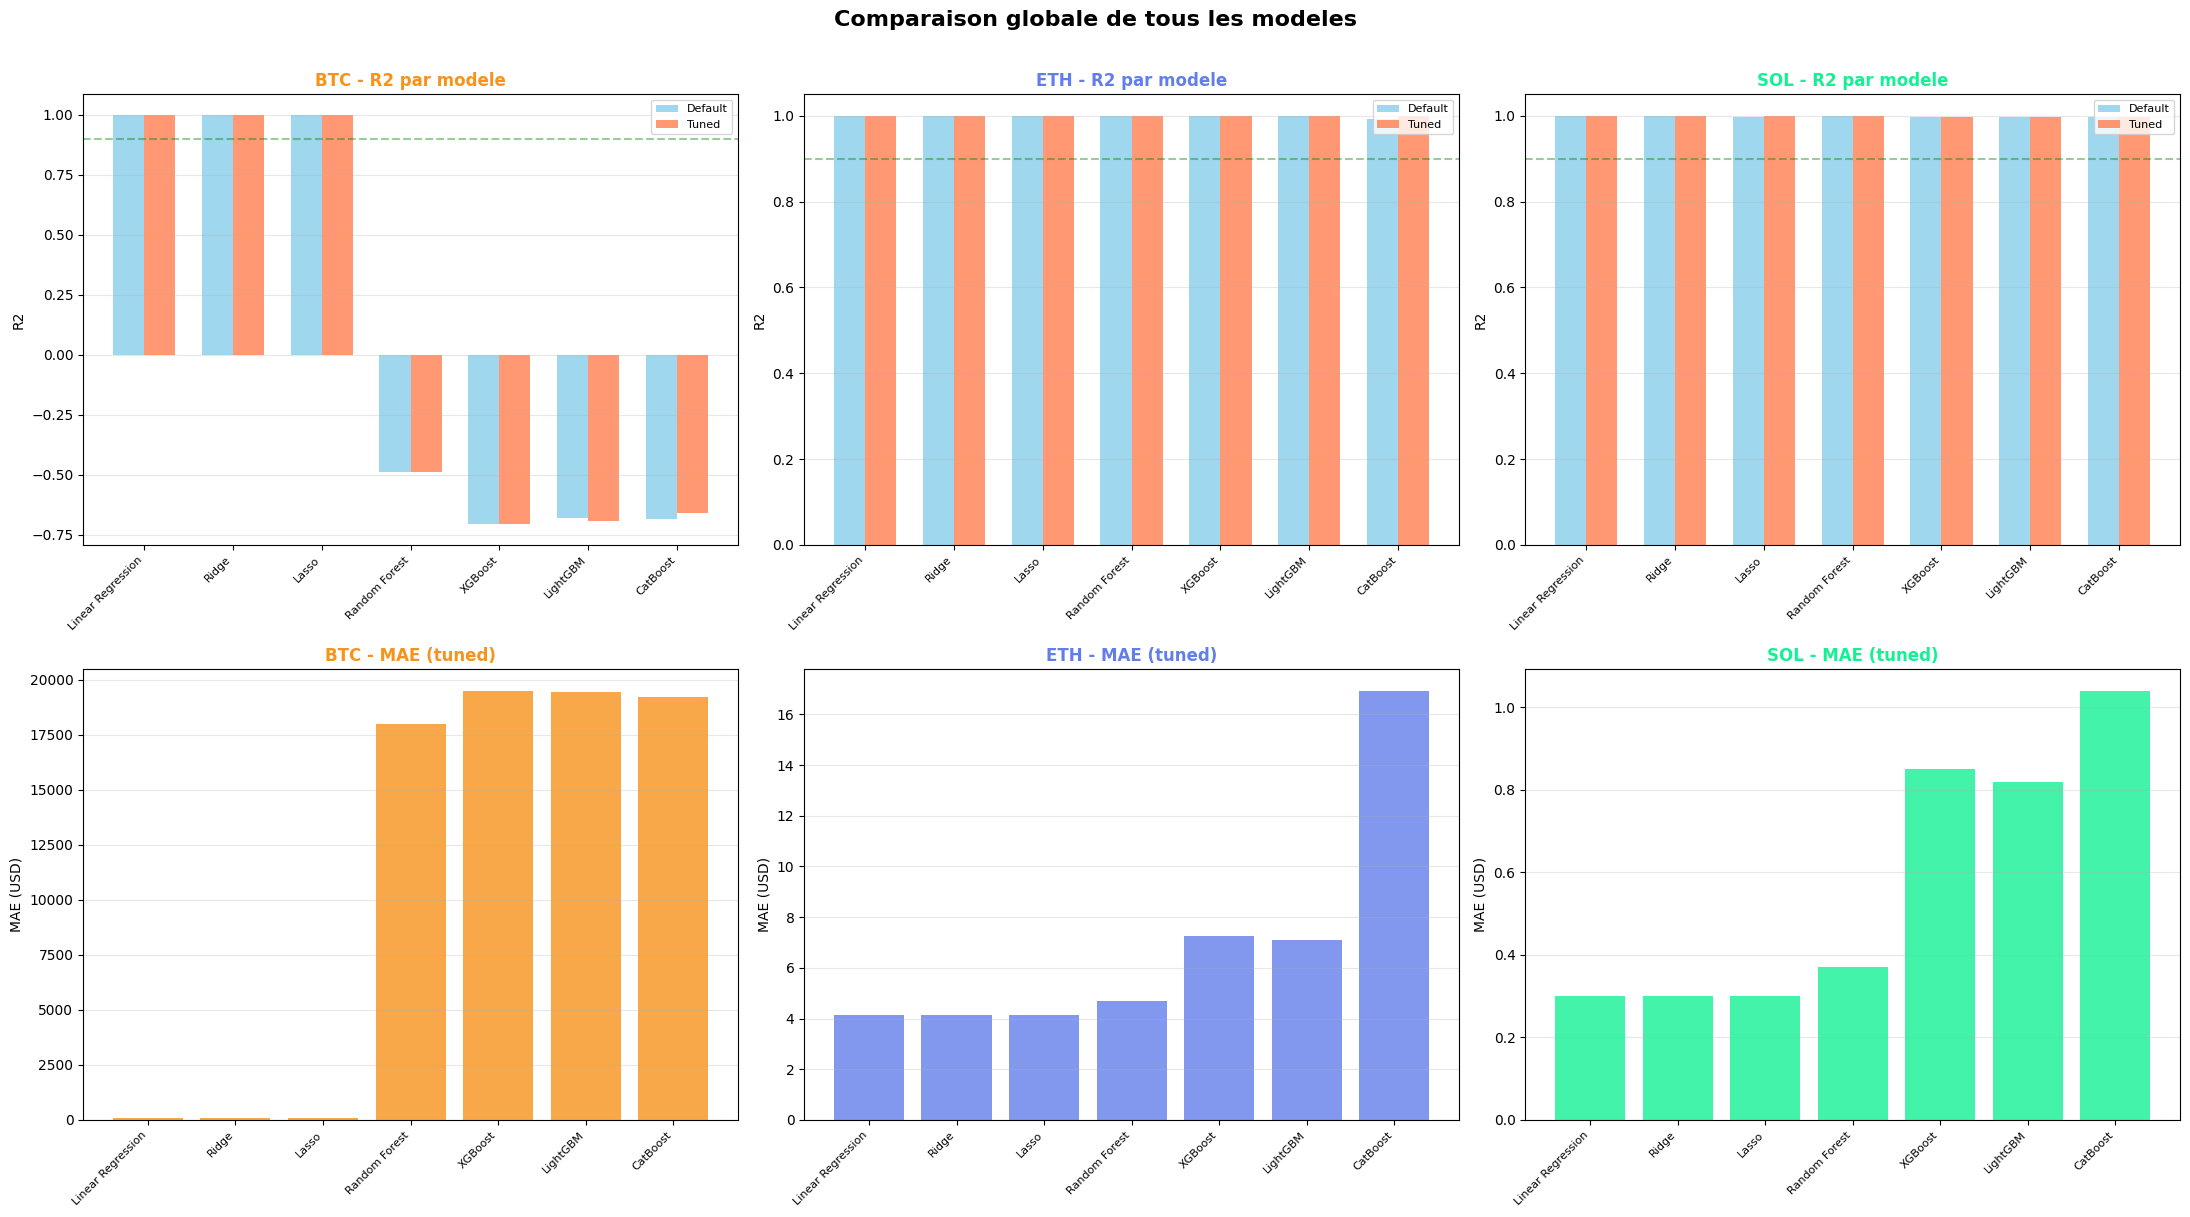

In [33]:
# Dashboard visuel
colors_crypto = {'BTC': '#F7931A', 'ETH': '#627EEA', 'SOL': '#14F195'}
all_models = df_recap['Modele'].unique()

fig, axes = plt.subplots(2, 3, figsize=(22, 12))

for idx, crypto in enumerate(['BTC', 'ETH', 'SOL']):
    subset = df_recap[df_recap['Crypto'] == crypto]
    x = np.arange(len(subset))
    w = 0.35

    # R2 default vs tuned
    ax = axes[0, idx]
    ax.bar(x - w/2, subset['R2 Default'], w, label='Default', alpha=0.8, color='skyblue')
    ax.bar(x + w/2, subset['R2 Tuned'], w, label='Tuned', alpha=0.8, color='coral')
    ax.set_title(f'{crypto} - R2 par modele', fontsize=12, fontweight='bold', color=colors_crypto[crypto])
    ax.set_xticks(x)
    ax.set_xticklabels(subset['Modele'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('R2')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')
    ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.4)

    # MAE tuned
    ax = axes[1, idx]
    ax.bar(x, subset['MAE Tuned'], color=colors_crypto[crypto], alpha=0.8)
    ax.set_title(f'{crypto} - MAE (tuned)', fontsize=12, fontweight='bold', color=colors_crypto[crypto])
    ax.set_xticks(x)
    ax.set_xticklabels(subset['Modele'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('MAE (USD)')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Comparaison globale de tous les modeles', fontsize=16, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('images/training/dashboard_comparison_global.png', dpi=300, bbox_inches='tight')
plt.show()

### Heatmap des performances R2 (modeles tuned)

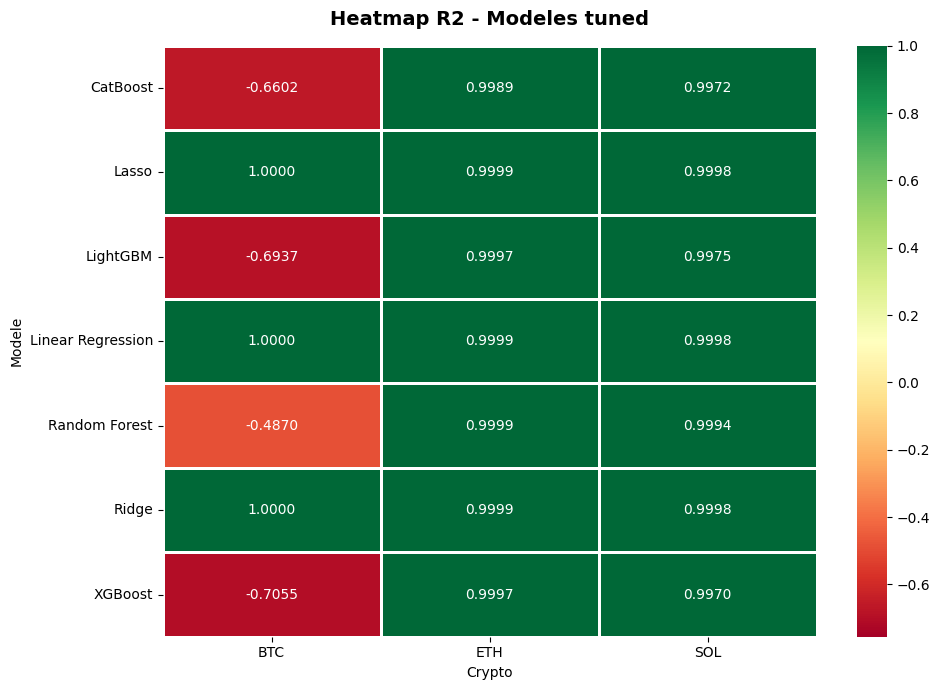

In [34]:
heatmap_data = df_recap.pivot(index='Modele', columns='Crypto', values='R2 Tuned')
heatmap_data = heatmap_data[['BTC', 'ETH', 'SOL']]

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', fmt='.4f', linewidths=1,
            vmin=heatmap_data.min().min() - 0.05, vmax=1.0)
plt.title('Heatmap R2 - Modeles tuned', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('images/training/heatmap_r2_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

### Amelioration default vers tuned

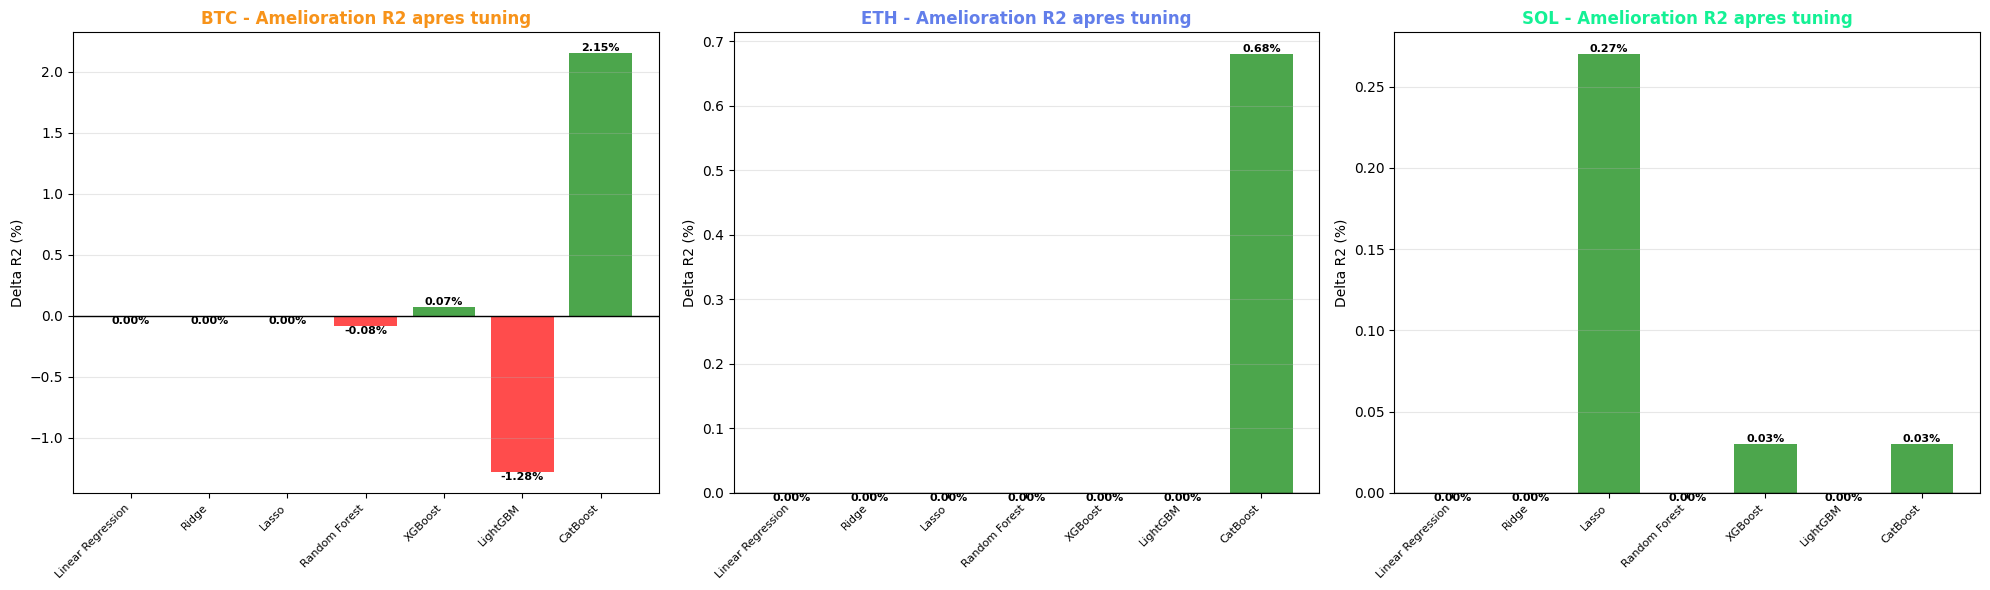

In [35]:
df_recap['Delta R2'] = df_recap['R2 Tuned'] - df_recap['R2 Default']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, crypto in enumerate(['BTC', 'ETH', 'SOL']):
    subset = df_recap[df_recap['Crypto'] == crypto]
    x = np.arange(len(subset))
    improvements = subset['Delta R2'].values * 100
    bar_colors = ['green' if v > 0 else 'red' for v in improvements]

    ax = axes[idx]
    bars = ax.bar(x, improvements, color=bar_colors, alpha=0.7)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_title(f'{crypto} - Amelioration R2 apres tuning', fontsize=12, fontweight='bold', color=colors_crypto[crypto])
    ax.set_xticks(x)
    ax.set_xticklabels(subset['Modele'], rotation=45, ha='right', fontsize=8)
    ax.set_ylabel('Delta R2 (%)')
    ax.grid(True, alpha=0.3, axis='y')

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., h,
                f'{h:.2f}%', ha='center', va='bottom' if h > 0 else 'top', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('images/training/improvement_default_to_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 10. Resume

### Meilleurs modeles par crypto

In [36]:
for crypto in ['BTC', 'ETH', 'SOL']:
    subset = df_recap[df_recap['Crypto'] == crypto].sort_values('R2 Tuned', ascending=False)
    best = subset.iloc[0]
    print(f"{crypto} : {best['Modele']} -> R2={best['R2 Tuned']:.4f}, MAE={best['MAE Tuned']:.2f}, RMSE={best['RMSE Tuned']:.2f}")

print(f"Amelioration moyenne apres tuning : {df_recap['Delta R2'].mean()*100:+.2f}%")

BTC : Linear Regression -> R2=1.0000, MAE=82.30, RMSE=129.07
ETH : Linear Regression -> R2=0.9999, MAE=4.14, RMSE=6.47
SOL : Linear Regression -> R2=0.9998, MAE=0.30, RMSE=0.46
Amelioration moyenne apres tuning : +0.09%


In [ ]:
import shutil
shutil.make_archive("images_archive", 'zip', "images")

'/home/jupyter/images_archive.zip'